# This Notebook is for exploring and running the leaf and canopy RTM models using JULIA 
## The programming Language used in the Notebook is Julia, Please install the latest Julia version and install the packages to run the Code
### Author: Debsunder Dutta
#### Date: Jan 23 2022

In [1]:
# Add Proper Paths to the Julia Environment
push!(LOAD_PATH, "D:/Balwant_Project/Project/Radiative_Transfer_Model/Code/Canopy/src/Utils/")
push!(LOAD_PATH, "D:/Balwant_Project/Project/Radiative_Transfer_Model/Code/Canopy/src/Leaf/")

5-element Vector{String}:
 "@"
 "@v#.#"
 "@stdlib"
 "D:/Balwant_Project/Project/Radiative_Transfer_Model/Code/Canopy/src/Utils/"
 "D:/Balwant_Project/Project/Radiative_Transfer_Model/Code/Canopy/src/Leaf/"

In [2]:
# Load the Modules Which Are Required
using ForwardDiff
using FluspectMod
using Plots
using BenchmarkTools
using CSV
using DataFrames
using Interpolations
using ArchGDAL
using GDAL

In [4]:
# Run the Fluspect and Benchmark
# Input State vector
x = [1.4;  80.0;  20.0;  0.0 ; 0.0;  0.009 ; 0.012;  0.;  3;-0.35]
@time R = FluspectMod.RTM_sail(x)
#@benchmark R = FluspectMod.RTM_sail(x)
@time dx =  ForwardDiff.jacobian(FluspectMod.RTM_sail,x)
#@benchmark dx =  ForwardDiff.jacobian(FluspectMod.RTM_sail,x)

 11.889775 seconds (29.00 M allocations: 1.520 GiB, 4.63% gc time, 99.35% compilation time)
 11.216441 seconds (31.78 M allocations: 1.599 GiB, 4.16% gc time, 99.02% compilation time)


8004×10 Matrix{Float64}:
 -2.90544e-8  -2.43941e-9  -6.29163e-9  …  -4.13577e-6  0.0  -0.00371716  0.0
 -2.74539e-8  -2.28366e-9  -5.73575e-9     -3.55903e-6  0.0  -0.00371819  0.0
 -2.61999e-8  -2.17643e-9  -5.30792e-9     -3.1114e-6   0.0  -0.00371946  0.0
 -2.52981e-8  -2.10342e-9  -5.02565e-9     -2.77722e-6  0.0  -0.00372074  0.0
 -2.49593e-8  -2.08812e-9  -4.93648e-9     -2.56524e-6  0.0  -0.00372201  0.0
 -2.53834e-8  -2.15907e-9  -5.07269e-9  …  -2.491e-6    0.0  -0.00372328  0.0
 -2.63714e-8  -2.29664e-9  -5.39421e-9     -2.51496e-6  0.0  -0.00372483  0.0
 -2.74291e-8  -2.44878e-9  -5.75339e-9     -2.54292e-6  0.0  -0.0037261   0.0
 -2.84595e-8  -2.60537e-9  -6.11766e-9     -2.56428e-6  0.0  -0.0037274   0.0
 -2.95098e-8  -2.77549e-9  -6.49498e-9     -2.59126e-6  0.0  -0.00372893  0.0
 -3.02325e-8  -2.90926e-9  -6.75037e-9  …  -2.56371e-6  0.0  -0.00373019  0.0
 -3.05694e-8  -2.9874e-9   -6.8783e-9      -2.47261e-6  0.0  -0.00373175  0.0
 -3.11683e-8  -3.1026e-9   -7.12751e-9 

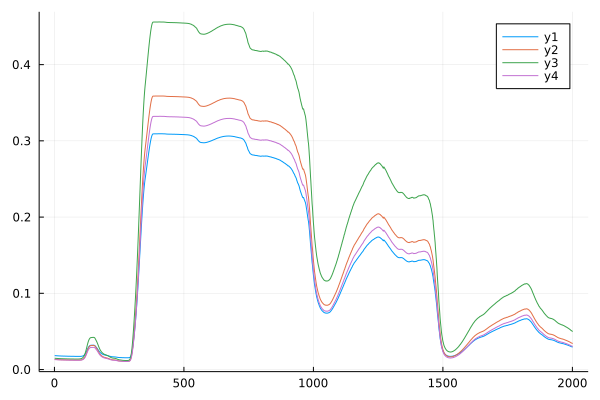

In [5]:
plot(R)

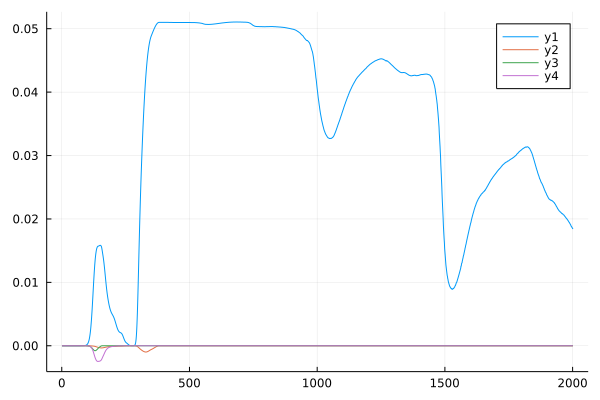

In [6]:
plot(dx[1:2001,1:4])


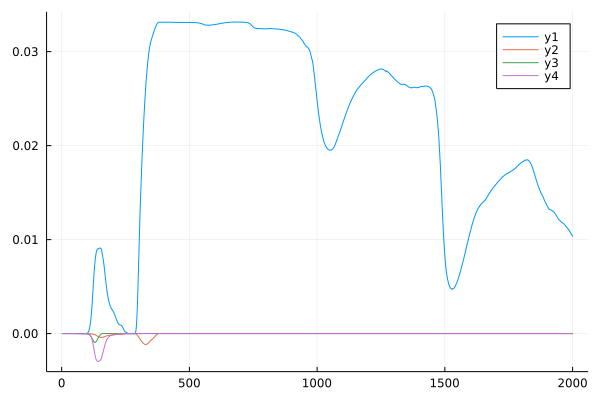

In [7]:
plot(dx[1+2000+1:2001+2000+1,1:4])

In [8]:
print(size(dx))


(8004, 10)

### The ForwardDiff Jacobian Just Basically computes the gradient of each of the observational vectors here the four 'y's which are the four components of the reflectance computations and then concatenates it as one single column. The different coulmns represents the different df/dxi's

## See if we can Optimize the Parameters

In [3]:
AVIRIS_ref = CSV.read("csv_file.csv", DataFrame);

In [4]:
band_center = AVIRIS_ref[:,2];

In [5]:
dataset = ArchGDAL.read("30_by_30_raster.tif")
Array = ArchGDAL.read(dataset)
width = ArchGDAL.width(dataset)
height = ArchGDAL.height(dataset)

30

In [6]:
using Optim
x0 = [1.1;  30.0;  10.0;  0.001 ; 0.001;  0.005 ; 0.02;  0.001;  4;-0.35]
lower = [1, 0,0,0,0,0,0,0,0,-0.45]
upper = [3, 120,50,0.1,0.1,00.1,0.1,0.1,6,-0.251]

wvl=collect(400.0:1:2400.);

function h(Array,lower,upper,x0)
    function g(x)
        R = FluspectMod.RTM_sail(x)
        return sum(abs.(LinearInterpolation(wvl, R[:,1]; extrapolation_bc=Line())(band_center).-Array))
    end
    results = optimize(g, lower, upper, x0, autodiff = :forward)
    return Optim.minimizer(results)
end

result = zeros(Float64, height,width,10);

for i in 1:height
    for j in 1:width 
        result[i,j,:] = h(Array[i,j,:],lower,upper,x0)
    end
end

┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches C:\Users\Kayal\.julia\packages\LineSearches\Ki4c5\src\hagerzhang.jl:148
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches C:\Users\Kayal\.julia\packages\LineSearches\Ki4c5\src\hagerzhang.jl:148
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches C:\Users\Kayal\.julia\packages\LineSearches\Ki4c5\src\hagerzhang.jl:148
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches C:\Users\Kayal\.julia\packages\LineSearches\Ki4c5\src\hagerzhang.jl:148
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches C:\Users\Kayal\.julia\packages\LineSearches\Ki4c5\src\hagerzhang.jl:148
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches C:\Users\Kayal\.julia\packages\LineSearches\Ki4c5\src\hagerzhang.jl:148
┌ Warning: Failed to achieve finit

┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches C:\Users\Kayal\.julia\packages\LineSearches\Ki4c5\src\hagerzhang.jl:148
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches C:\Users\Kayal\.julia\packages\LineSearches\Ki4c5\src\hagerzhang.jl:148
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches C:\Users\Kayal\.julia\packages\LineSearches\Ki4c5\src\hagerzhang.jl:148
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches C:\Users\Kayal\.julia\packages\LineSearches\Ki4c5\src\hagerzhang.jl:148
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches C:\Users\Kayal\.julia\packages\LineSearches\Ki4c5\src\hagerzhang.jl:148
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches C:\Users\Kayal\.julia\packages\LineSearches\Ki4c5\src\hagerzhang.jl:148
┌ Warning: Failed to achieve finit

In [12]:
Leaf_structure_Index_N = result[:,:,1]

30×30 Matrix{Float64}:
 1.0      2.74809  3.0      2.19958  …  1.0      1.0      1.0      2.20526
 1.78899  3.0      2.53568  1.26961     1.0      1.0      1.0      2.82777
 1.00236  1.0      1.0      1.0         1.0      1.74542  2.95496  2.99999
 1.0      1.0      1.0      2.49252     1.0      1.0      2.62368  3.0
 1.82423  1.0      1.0      1.88419     1.0      1.00634  1.00284  2.58444
 2.24269  1.0      1.0      2.64296  …  1.00002  1.0      1.22674  2.18532
 1.0      1.0      1.0      3.0         1.0      1.0      2.27306  2.09046
 3.0      1.0      2.59892  2.88553     1.47084  2.60808  2.95657  3.0
 1.0      1.20501  3.0      3.0         3.0      3.0      2.17643  2.68596
 1.00189  1.0      1.0      1.0         3.0      3.0      1.0      1.0
 1.8693   1.0      1.0      1.0      …  2.72287  2.88797  1.0      1.0
 2.43342  1.0      1.0      2.91291     1.0      1.0      1.0      1.00001
 2.07368  1.0      1.0      2.54619     1.0      1.0      1.0      3.0
 ⋮                    

In [10]:
chlorophyll = result[:,:,2]

30×30 Matrix{Float64}:
 107.884   120.0      97.4781   46.0914  …  120.0      80.5235  119.999
 120.0      95.8959  120.0      87.6251      98.2113   79.7486  120.0
 116.964   120.0     120.0     103.596       74.786    63.2696   89.6374
  47.9466   72.6609  119.993   119.773       61.2884   68.4713   77.0332
  50.1135   71.4447  118.832   120.0        118.067   119.18    120.0
  79.0727  103.166   114.919   120.0     …  119.307   104.455   120.0
  80.526    90.4072   90.8491  117.335      103.169   119.746   120.0
 103.516    67.703   120.0     120.0        118.461   120.0     111.865
  83.2725  103.7     112.407   113.976       85.8281  120.0     120.0
 119.634   120.0     119.999    99.8871      78.9229   91.1162   97.4133
 120.0     119.999   120.0      97.6454  …   85.3264   99.8764  113.943
 113.292    97.1431  120.0      86.3276      85.0173   83.296    87.2798
 107.161    82.8122   85.624    80.2129     109.206    68.7359   76.1947
   ⋮                                     ⋱    

In [11]:
carotenoid = result[:,:,3]

30×30 Matrix{Float64}:
 50.0     50.0     41.7614  28.9016  …  50.0     27.4712  34.848    49.9995
 50.0     42.0899  50.0     39.322      40.3698  50.0     41.5151   50.0
 45.9415  50.0     49.0979  44.1782     50.0     49.1096  34.7543   36.9288
 22.455   22.5374  49.9961  49.663      50.0     40.9223  40.3082   33.0865
 32.1535  33.44    50.0     50.0        20.252   29.245   46.2873   50.0
 49.9983  48.0284  50.0     50.0     …  14.8005  50.0     50.0      50.0
 26.7996  22.7214  50.0     50.0        47.7036  50.0     49.6088   50.0
 50.0     29.6014  49.9997  49.9999     50.0     50.0     50.0      50.0
 35.6718  50.0     50.0     50.0        40.8024  43.5051  50.0      50.0
 47.7123  49.997   49.9972  50.0        27.5046  37.9592  40.7578   42.8447
 50.0     49.9977  24.8093  33.3909  …  50.0     50.0     31.0543   30.7099
 48.0111  39.8826  30.1567  36.393      21.7315  16.3767  21.7542   22.9819
 47.9094  32.2867  35.3138  35.2766     16.8425  19.6262  34.5129   41.9774
  ⋮    

In [14]:
LAI = result[:,:,9]

30×30 Matrix{Float64}:
 1.77562  1.7767   2.14825  6.0      …  2.19528  2.43771  1.75558  1.68868
 1.72302  2.30693  2.01113  1.78519     2.29006  1.51308  1.6664   1.78448
 1.84767  1.87795  2.05487  1.67693     1.65394  1.55151  2.62402  2.82636
 2.52237  2.70194  1.79735  1.43699     1.65558  1.65957  2.04215  3.21336
 2.42209  2.03852  1.68674  1.33347     3.01661  2.57914  2.09409  1.74862
 2.02391  1.8295   1.69086  1.39478  …  3.05704  1.7317   1.55485  1.65095
 2.11685  2.16599  1.46073  1.39764     1.71446  1.52658  1.465    1.60533
 2.01041  1.79147  1.50345  1.39662     1.59813  1.71279  1.72364  1.9639
 1.80817  1.64698  1.8123   1.64958     2.17059  2.27274  1.61569  1.84427
 1.92642  2.08057  2.04215  1.62639     3.67038  3.0148   1.85446  1.8863
 1.63548  1.7967   2.21947  1.74059  …  2.00145  2.45338  2.31939  2.15459
 1.93825  1.90007  2.42874  2.3374      2.69442  2.58082  2.57274  2.30596
 2.08375  1.91758  1.81827  2.04837     3.10348  2.79382  2.01793  2.83552
 ⋮  

In [5]:
using Optim
x0 = [1.1;  30.0;  10.0;  0.001 ; 0.001;  0.005 ; 0.02;  0.001;  4;-0.35]
lower = [1, 0,0,0,0,0,0,0,0,-0.45]
upper = [3, 120,50,0.1,0.1,00.1,0.1,0.1,6,-0.251]


function g(x)
    R = FluspectMod.RTM_sail(x)
    return sum(abs.(R[:,1].-y))
end

results = optimize(g, lower, upper, x0, autodiff = :forward)

 * Status: success

 * Candidate solution
    Final objective value:     5.960741e-12

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 4.00e-01 ≰ 1.0e-08

 * Work counters
    Seconds run:   43  (vs limit Inf)
    Iterations:    5
    f(x) calls:    3126
    ∇f(x) calls:   3126


In [23]:
results

 * Status: success

 * Candidate solution
    Final objective value:     9.549598e+01

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 3.36e-15 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.66e-17 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 3.39e-02 ≰ 1.0e-08

 * Work counters
    Seconds run:   203  (vs limit Inf)
    Iterations:    10
    f(x) calls:    19449
    ∇f(x) calls:   19449


In [15]:
Optim.summary(result)

"30×30×10 Core.Array{Float64, 3}"

In [19]:
xopt = result[1,1,:]

10-element Vector{Float64}:
   1.0000000000000002
 107.8835152705162
  49.99999999999999
   0.042464214212908635
   0.09999999999999999
   0.015411999751893404
   0.026061189148955225
   0.09999999999999996
   1.7756223522613503
  -0.35104017279764843

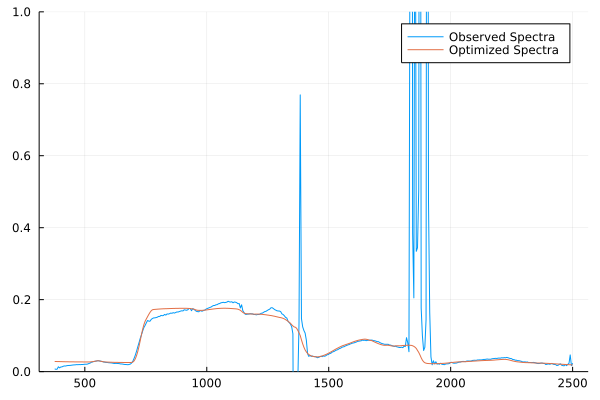

In [20]:
# xopt=Optim.minimizer(results)
Ropt = LinearInterpolation(wvl, FluspectMod.RTM_sail(xopt)[:,1]; extrapolation_bc=Line())(band_center)
# wvl=collect(400.0:1:2400.)
plot(band_center,Array[1,1,:],label="Observed Spectra",ylims=(0,1))
plot!(band_center,Ropt,label="Optimized Spectra",ylims=(0,1))

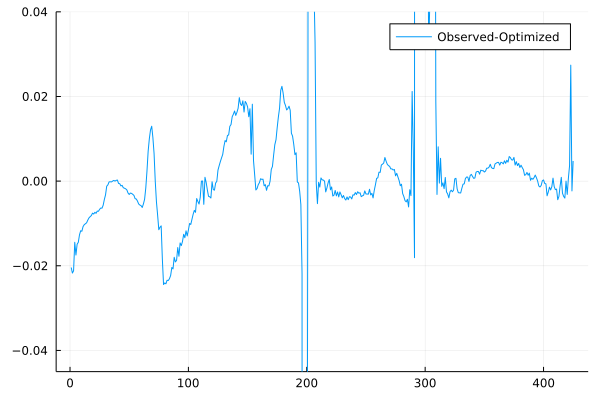

In [21]:
plot(Array[1,1,:]-Ropt,label="Observed-Optimized",ylims=(-0.045,0.04))
